In [267]:
""" simple thermal evolution model, mantle and core """

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from collections import Iterable
import six
import math

In [268]:
""" universal constants """

M_E = 5.972e24 # earth mass in kg
R_E = 6371e3 # earth radius in m
L_sun =  3.9e26 # solar luminosity in W
#Q_cmb_Earth = 11e12 # heat flux from (Earth's) core in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4
R_b = 8.3144598 # universal gas constant in J mol −1 K −1

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

In [260]:
print(rho_m*h_rad(t=0, tf=4.5e9*years2sec, H_0=np.array(H_0)*10, X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                  t_half=np.array(t_half)*years2sec,  t_vect=False))
print(rho_m*h_rad(t=4.5e9*years2sec, tf=4.5e9*years2sec, H_0=np.array(H_0)*10, X_0=np.array(X_0)*1e-6, 
                  el_0=np.array(el_0), t_half=np.array(t_half)*years2sec, t_vect=False))

1.62551137e-07
8.689931245925947e-08


In [269]:
"""surface/space interface"""

def luminosity(tau, L=None, **kwargs):
    return L
    
def q_star(t=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return luminosity(t, **kwargs)*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def q_sfc_outgoing(R_p=None, SA_p=None, **kwargs):
    return q_star(**kwargs)*(np.pi*R_p**2)/SA_p # assume no geothermal contribution, pi*R^2 cancels out

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

In [270]:
"""geometry"""

def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius_by_vol(V):
    return (3*V/(4*np.pi))**(1/3)

def radius_basic(M_p, CRF, rho_m, rho_c):
    """Calculate radius of planet given total mass, assume lid (bndy layer) has the same density as mantle
    
    Parameters
    ----------
    M_p : float
        Mass of planet
    rho_m : float
        Mantle density
    F_c : float
        Core fraction in terms of radius
    rho_c : float
        Core density
    """
    
    R_p = ( 3*M_p/(4*np.pi) / (rho_m - CRF**3*rho_m + CRF**3*rho_c) )**(1/3)
    return R_p

def radius_seager(M_p, CMF=0.3, k1=-0.20945, k2=0.0804, k3=0.394, m1=None, r1=None):
    if (m1 is None) and (r1 is None):
        if CMF==0.3:
            m1 = 6.41*M_E
            r1 = 2.84*R_E
        elif CMF==0.675:
            m1 = 6.41*M_E
            r1 = 3.19*R_E
        elif CMF==0: # all perovskite
            m1 = 7.38*M_E
            r1 = 3.58*R_E
    M_s = M_p/m1
    R_s = 10**(k1 + 1/3*np.log10(M_s) - k2*M_s**k3)
    return R_s*r1

def radius_otegi(M_p):
    return np.exp(1/3.45*np.log(M_p/0.9))

def radius_zeng(M_p, CMF=None):
    # applicable to M_E <= 8 and CMF <= 0.4
    print('using Zeng radius model')
    return (1.07 - 0.21*CMF)*(M_p/M_E)**(1/3.7)

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)
    
def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

In [271]:
"""thermodynamics"""

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    #print('kappa', k/(rho*C_p), 'm^2 s^-1')
    return k/(rho*C_p)

def nu_Driscoll(T, nu_0=7e7, Ea=3e5, **kwargs):
    """kinematic viscosity (upper mantle) from eqn 6 in Driscoll & Bercovici"""
    return nu_0*np.exp(Ea/(R_b*T))/10

def nu_Dorn(T, nu_0=1.6e20, Ea=300e3, T_0=1800, **kwargs):
    # viscosity (below lithosphere) from Dorn, Noack & Rozal 2018
    return nu_0*np.exp(Ea/R_b*(T**-1-T_0**-1))

def nu_KW(T, p=0, **kwargs): # Karato & Wu 1993, diffusion law for dry olivine
    return 2.6e10*np.exp((3e5 + (6e3*p))/(R_b*T))   

def eta_Thi(T, eta_0=1e21, T_ref=1600, Ea=300e3, **kwargs): # diffusion creep, dry rheology (Thiriet+ 2019)
    return eta_0*np.exp(Ea/R_b*(T**-1 - T_ref**-1))

def adiabat(T_0, R=None, g=None, R_p=None, h=None, c_v=None, alpha_m=None, adiabatic=True, **kwargs):
    if adiabatic:
        R_0 = R_p - 0.5*h # depth to avg mantle temp (taken to be midpoint between surface and cmb)
        u = np.exp(-(R - R_0)*alpha_m*g/c_v) # page 39 driscoll & bercovici 2014
        #print('adiabatic T decrease', u)
        return u*T_0
    else:
        return T_0

def Ra(nu=None, eta=None, kappa=None, alpha=None, rho=None, g=None, deltaT=None, l=None):
    if (nu is None) and (eta is not None):
        return rho*alpha*deltaT*l**3*g/(kappa*eta)
    elif (nu is not None) and (eta is None):
        return alpha*deltaT*l**3*g/(kappa*nu)

In [272]:
""" topography """

def dyn_topo(F, rho_m=None, rho_w=1000, alpha_m=None, eta_m=None, kappa_m=None, g_sfc=None, 
             k_m=None, C=5.4, **kwargs):
    return C*rho_m/(rho_m-rho_w) * ((alpha_m*F*eta_m*kappa_m)/(rho_m*g_sfc*k_m))**(1/2) # eqn 33 Parsons & Daly

In [273]:
"""stagnant lid thermal model adapted from Thiriet+ 2019"""

def init(k_m=None, rho_m=None, rho_c=None, c_pm=None, CMF=None, M_p=None, **kwargs):
    R_p = radius_zeng(M_p, CMF)*R_E # in m
    M_m = M_p*(1 - CMF) # mass of mantle
    CRF = CMF**0.5 # Zeng & Jacobsen 2017
    R_c = R_p*CRF
    #R_c = radius_seager(M_p*CMF, CMF=0, m1=4.34*M_E, r1=2.23*R_E) # EoS for iron... is this consistent?
    SA_p = SA(R=R_p)
    SA_c = SA(R=R_c) # core surface area 
    M_c = 4/3*np.pi*R_c**3 * rho_c # M_p - M_m
    #print('SA_c', SA_c)
    #print('SA_p', SA_p)
    h = R_p - R_c # mantle thickness
    g_sfc = grav(M_p, R_p)
    if CMF>0:
        g_cmb = grav(M_p*CMF, R_c)
    else:
        g_cmb = 0
    kappa_m = thermal_diffusivity(k_m, rho_m, c_pm)
    print('kappa_m', kappa_m)
    return dict(kappa_m=kappa_m, SA_p=SA_p, SA_c=SA_c, M_m=M_m, g_sfc=g_sfc, R_p=R_p, R_c=R_c,
                CRF=CRF, g_cmb=g_cmb, h=h, M_c=M_c)

def dyn_visc(T=None, nu_0=None, visc_type=None, rho_m=None, **kwargs):
    if visc_type=='constant':
        return nu_0*rho_m
    elif visc_type=='Dorn':
        return nu_Dorn(T, **kwargs)*rho_m
    elif visc_type=='KW':
        return nu_KW(T, **kwargs)*rho_m
    elif visc_type=='Driscoll':
        return nu_Driscoll(T, **kwargs)*rho_m
    elif visc_type=='Thi':
        return eta_Thi(T, **kwargs)

def bdy_thickness_beta(dT=None, R_l=None, R_c=None, Ra_crit=None, Ra_rh=None, beta=None, g=None,
                  kappa_m=None, eta_m=None, Ea=None, alpha_m=None, rho_m=None, a_rh=None,**kwargs):
    """Thickness of thermal boundary layer """
    return (R_l - R_c) * (Ra_crit/Ra_rh)**beta
    
def bdy_thickness(dT=None, Ra_crit=None, g=None, kappa_m=None, eta_m=None, alpha_m=None, rho_m=None, 
                  **kwargs):
    """Thickness of thermal boundary layer """
    return (Ra_crit*kappa_m*eta_m/(alpha_m*rho_m*g*dT))**(1/3)
    
def h_rad(t=None, tf=None, H_0=None, X_0=None, el_0=None, t_half=None, t_vect=False, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not t_vect:
        return sum(H_0*X_0*el_0*np.exp(-np.log(2)*t/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(t))
        for ii, val in enumerate(t):
            h[ii] = sum(H_0*X_0*el_0*np.exp(-np.log(2)*val/t_half))
        return h
        
def Q_rad(t=None, M_m=None, **kwargs):
    """Calculate energy flux radioisotope decay in W"""
    h = h_rad(t, **kwargs)
    return h*M_m # mass cancels out

def q_bl(deltaT, k=None, d_bl=None, beta=None, **kwargs):
    if beta is None:
#         print('delta T', deltaT, 'k', k, 'd_bl', d_bl)
        return k*deltaT/d_bl #a_BL*Ra_rh**beta_BL * k*deltaT/h

def Q_bl(q=None, deltaT=None, SA=None, h=None, d_bl=None,
         adiabatic=False, beta=None, Ra_rh=None, **kwargs):
    """Calculate energy flux from conduction across thermal bdy layer in W""" 
    if q is None:
        return SA*q_bl(deltaT, k=k, d_bl=d_bl, beta=beta, **kwargs)
    else:
        return SA*q

def T_lid(T_m, a_rh=None, Ea=None, **kwargs):
    return T_m - a_rh*(R_b*T_m**2/Ea) # temperature at base of stagnant lid, Thiriet+ eq. 15
 
def dTdt(t, y, T_s=None, M_m=None, M_c=None, c_v=None, c_vc=None, SA_p=None, SA_c=None, 
         g_sfc=None, g_cmb=None, R_p=None, R_c=None, k_m=None, k_lm=None, Ra_crit_u=None,
         beta_u=None, beta_c=None, rho_lith=None,
         adiabats=0, **kwargs):
    """R.H.S. of ODE for mantle temperature change"""
    #print('t, T', t, T)
    T_m = y[0]
    T_c = y[1]

    T_l = T_lid(T_m, **kwargs)
#     print('T_l', T_l)
    if (beta_u is None) or (beta_c is None):
        h = None
        D_l = None
    else:
        pass
    adiabatic=False
    

    eta_m = dyn_visc(T=T_m, **kwargs)
    eta_cmb = dyn_visc(T=(T_c+T_m)/2, **kwargs)
    nu_m = eta_m/rho_m
    nu_cmb = eta_cmb/rho_m
    
#     R_l = R_p - D_l # radius at lid base
#     h = R_l - R_c # depth of convecting layer (mantle)
#     Ra_rh_u = Ra(eta=eta_m, kappa=kappa_m, alpha=alpha_m, rho=rho_m, g=g_sfc, deltaT=T_m-T_l, l=h)
#     Ra_rh_c = Ra(eta=eta_cmb,kappa=kappa_m, alpha=alpha_m, rho=rho_m, g=g_cmb, deltaT=T_c-T_m, l=h)
    
    TBL_u = bdy_thickness(dT=T_m-T_l, eta_m=eta_m, g=g_sfc, Ra_crit=Ra_crit_u, **kwargs)
    
#     print('eta_m', eta_m)
#     print('delta_u = ', TBL_u)
    
    q_rad = h_rad(t, **kwargs) # W kg^-1
    H_rad = Q_rad(t, M_m=M_m, **kwargs) # mantle radiogenic heating in W
     
    q_tbl = q_bl(deltaT=T_m-T_l, k=k_m, d_bl=TBL_u, beta=beta_u, **kwargs)
    
    D_lid = d_lid(Tm=T_m, k=k_m, H0=q_rad*rho_m, Ra_crit=Ra_crit_u, Ts=T_s, g_sfc=g_sfc, **kwargs)
    #D_lid = d_lid(H=q_rad*rho_m, q_u=q_tbl, T_m=T_m, k_m=k_m, T_s=T_s, T_l=T_l, **kwargs)
    R_l = R_p - D_lid
    
    F_bl = Q_bl(q_tbl, SA=4*np.pi*R_l**2) #Q_bl(deltaT=T_m-T_l, k=k_m, SA=4*np.pi*R_l**2, d_BL=TBL_u,a_BL=a_BL_u, beta_BL=beta_BL_u, Ra_rh=Ra_rh_u, **kwargs)  # heat flux through lid in W
    
    Ra_i = Ra(eta=eta_m, kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=rho_m, 
              g=g_sfc, deltaT=T_m-T_l, l=R_l-R_c)
    
    if SA_c>0:
        Ra_crit_c = 0.28*Ra_i**0.21  
        TBL_c = bdy_thickness(dT=T_c-T_m, eta_m=eta_cmb, g=g_cmb, Ra_crit=Ra_crit_c, **kwargs)  
        q_core = q_bl(deltaT=T_c-T_m, k=k_lm, d_bl=TBL_c, beta=beta_c, **kwargs)
        F_core = Q_bl(q_core, SA=SA_c) #Q_bl(deltaT=T_c-T_m, k=k_lm, SA=SA_c, d_BL=TBL_c,a_BL=a_BL_c, beta_BL=beta_BL_c, Ra_rh=Ra_Rh_c, **kwargs) # core flux in W
        dTdt_c = -F_core/(M_c*c_vc)
    else:
        F_core = 0
        dTdt_c = 0
    
    
    
    # TODO: recalculate M_m - can you just remove density of lid
    V_lid = 4/3*np.pi*(R_p**3 - R_l**3)
    M_lid = V_lid*rho_lith # should use another density?
    M_mi = M_m - M_lid
#     print('M_mantle =', M_mi, 'kg')
    
    dTdt_m = (-F_bl + H_rad + F_core)/(M_mi*c_v)
    
    return [dTdt_m, dTdt_c]

def solve_Tm(tf=None, T_m0=None, T_c0=None, t0=0, plots=False, plots_save=False, fend='', 
             M_p=None, T_s=None, **kwargs):
    derargs = init(M_p=M_p, **kwargs)
    if T_s is None:
        q_out = q_sfc_outgoing(**derargs, **kwargs)
        T_s = T_sfc(q_out)
    f = integrate.solve_ivp(fun=lambda t, y: dTdt(t, y, **dict(T_s=T_s, M_p=M_p,
                                                  **derargs, **kwargs)), 
                            t_span=(t0,tf), y0=[T_m0, T_c0], max_step=100e6*years2sec,
                            method='RK45', t_eval=None, dense_output=False, events=None)
    if plots:
        plot_results(f, **dict(T_s=T_s, M_p=M_p), plots_save=plots_save, **derargs, **kwargs)
    return f.t, f.y



In [276]:
""" plotting """

def plot_results(f, plots_save=False, **kwargs):
    print('R_p =', '%.2f'%(kwargs['R_p']/R_E), 'R_E')
    #print('M_mantle', '%.2f'%(kwargs['M_m']/M_E), 'M_E')
    print('g_sfc =', '%.2f'%kwargs['g_sfc'], 'm s^-2')
    print('g_cmb =', '%.2f'%kwargs['g_cmb'], 'm s^-2')
    #print('SA_p =', '%.2f'%(kwargs['SA_p'])
    print('SA_c =', '%.2f'%(kwargs['SA_c']/kwargs['SA_p']), 'x SA_p')
    print('CRF =', '%.2f'%kwargs['CRF'])
    print('T_s =', '%.2f'%kwargs['T_s'], 'K')
    print('viscosity method:', kwargs['visc_type'])
    rad_flux = h_rad(f.t, t_vect=True, **kwargs)
    rad_heating = Q_rad(f.t, t_vect=True, **kwargs)
    T_l = T_lid(f.y[0], **kwargs) 
    eta_m = dyn_visc(T=f.y[0], **kwargs) # dynamic viscosity
    eta_cmb = dyn_visc(T=(f.y[1]+f.y[0])/2, **kwargs)

    
#     if kwargs['adiabats']<2:
#         adiabatic=False # change delta T
    d_TBL = bdy_thickness(dT=f.y[0]-T_l, eta_m=eta_m, g=kwargs['g_sfc'], 
                          Ra_crit=kwargs['Ra_crit_u'], **kwargs)
    tbl_flux = q_bl(f.y[0]-T_l, k=kwargs['k_m'], d_bl=d_TBL, **kwargs)
    
    D_lid = d_lid(Tm=f.y[0], k=kwargs['k_m'], H0=rad_flux*kwargs['rho_m'], Ra_crit=kwargs['Ra_crit_u'],
                  Ts=kwargs['T_s'], **kwargs)
    R_l = kwargs['R_p'] - D_lid
    
    tbl_cooling = Q_bl(q=tbl_flux, SA=4*np.pi*R_l**2, **kwargs) #*5

    urey = rad_heating/tbl_cooling

#     adiabatic=False
#     if kwargs['adiabats']>0:
#         adiabatic=True # change delta T
    Ra_i = Ra(eta=eta_m, kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=kwargs['rho_m'], 
              g=kwargs['g_sfc'], deltaT=f.y[0]-T_l, l=R_l-kwargs['R_c']) # mantle Ra
    Ra_crit_c = 0.28*Ra_i**0.21  
    d_lbl = bdy_thickness(dT=f.y[1]-f.y[0], eta_m=eta_cmb, g=kwargs['g_cmb'], Ra_crit=Ra_crit_c, 
                          **kwargs)  
    core_flux = q_bl(deltaT=f.y[1]-f.y[0], d_bl=d_lbl, k=kwargs['k_lm'], 
                        g=kwargs['g_cmb'], adiabatic=False, 
                        **kwargs)
    core_heating = Q_bl(q=core_flux, SA=kwargs['SA_c'])

    fig, axes = plt.subplots(3, 5, figsize=(13,9))
    plot_one(axes[0][0], f.t*1e-6/years2sec, 
             f.y[0],
             '', '$T_m$ (K)', ylim=[0, 3500])
    #plot_structure(axes[0][1], R_p, R_cmb)
    plot_one(axes[0][1], f.t*1e-6/years2sec, 
             d_TBL*1e-3, 
             '', 'Upper TBL thickness (km)')
    plot_one(axes[0][2], f.t*1e-6/years2sec, 
             eta_m, 
             '', 'Rayleigh number')
    plot_one(axes[0][3], f.t*1e-6/years2sec, 
             tbl_flux*1e3, 
             '', '$q_{ubl,out}$ (mW/m$^2$)')
    plot_one(axes[1][0], f.t*1e-6/years2sec, 
             tbl_cooling*1e-12, 
             '', '$Q_{ubl,out}$ (TW)')
    plot_one(axes[1][1], f.t*1e-6/years2sec, 
             rad_heating*1e-12,
             '', '$Q_{rad}$ (TW)')
    plot_one(axes[1][2], f.t*1e-6/years2sec, 
             urey, 
             '', 'Urey ratio')

    plot_one(axes[1][3], f.t*1e-6/years2sec, 
             rad_flux*kwargs['rho_m']*1e6,
             '', '$q_{rad}$ ($\mu$W/m$^3$)')
    try:
        plot_one(axes[0][4], f.t*1e-6/years2sec, 
                 core_heating*1e-12, 
                 '', '$Q_{cmb}$ (TW)')
    except ValueError:
        pass
    try:
        plot_one(axes[1][4], f.t*1e-6/years2sec, 
                 eta_m,
                 '', r'$\nu_{m}$ (m$^2$s$^{-1}$)')
    except ValueError:
        plot_one(axes[1][4], f.t*1e-6/years2sec, 
                 [kwargs['nu_m']]*len(f.t),
                 '', r'$\nu_{m}$ (m$^2$s$^{-1}$)')
#     plot_one(axes[2][0], f.t*1e-6/years2sec, 
#              adiabat(f.y[0], kwargs['R_p'], kwargs['g_sfc'], adiabatic=True, **kwargs, **derargs), 
#              '', '$T_{UM}$ (K)')
#     plot_one(axes[2][1], f.t*1e-6/years2sec, 
#              adiabat(f.y[0], kwargs['R_c'], kwargs['g_cmb'], adiabatic=True, **kwargs, **derargs),
#              '', '$T_{LM}$ (K)')
#     plot_one(axes[2][3], f.t*1e-6/years2sec, 
#              urey**-1,
#              '', '$E/F(t)$')
    plot_one(axes[2][2], f.t*1e-6/years2sec, 
             f.y[1],
             '', '$T_{core}$ (K)', ylim=[0, 3500])
    plot_one(axes[2][4], f.t*1e-6/years2sec, 
             dyn_topo(tbl_flux, rho_w=0, eta_m=eta_m, **kwargs),
             '', 'dynamic topography (m)')
    plot_one(axes[2][3], f.t*1e-6/years2sec,
             D_lid*1e-3,
             '', '$d_{l}$ (km)'
            )
    plot_setxlabel(axes, 'Age (Myr)', 'all')
    axes[0][0].set_title('%.2f'%(kwargs['M_p']/M_E)+' M$_E$, CMF='+str(CMF))
    plt.tight_layout()
    if plots_save:
        fig.savefig('figs/evol_M'+'%.2f'%(M_p/M_E)+'_CMF'+str(CMF)+'.png', bbox_inches='tight')

def plot_structure(ax=None, R_p=None, R_cmb=None, labelsize=12, legsize=14, **kwargs):
    x=[0, 1]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_ylabel('$z$ (km)', fontsize=labelsize)
    ax.set_xticks([])
    ax.set_ylim([0, R_p*1e-3])
    ax.fill_between(x=x, y0=[0]*len(x), y1=[R_cmb*1e-3]*len(x), color='xkcd:gold') # core
    ax.text(0, 0, 'Core', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    ax.fill_between(x=x, y0=[R_cmb*1e-3]*len(x), y1=[R_p*1e-3]*len(x), color='xkcd:tomato') # mantle
    ax.text(0, R_cmb*1e-3, 'Mantle', ha='left', va='bottom', transform=ax.transAxes, fontsize=legsize)
    #ax.axhline(y=R_p*1e-3)
    return ax

def plot_one(ax, x, y, xlabel, ylabel, labelsize=12, legsize=14, lw=1, ls='-', marker=None, 
             ms=5,c='k', text=None, xticks=True, ylim=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    if not xticks:
        ax.set_xticks([])
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.plot(x, y, c=c, lw=lw, ls=ls, marker=marker, ms=ms)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left', va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plot_setxlabel(axes, label, style, labelsize=12):
    ny, nx = np.shape(axes) # assume 2D
    for ii, ax in enumerate(axes):
        for jj, a in enumerate(ax):
            if (style=='all') or ((style=='bottom') and (jj==ny-1)):
                a.set_xlabel(label, fontsize=labelsize)
            if (style=='bottom') and (jj<ny-1):
                a.set_xticks([])


In [277]:
""" default model input parameters """

L=1 # stellar luminosity in solar units
Alb=0 # planetary albedo
a = 1 # semimajor axis in au

Ra_crit = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 3300 #4500 # Density of silicate mantle in kg m^-3 
# what pressure should you take these densities at?
c_pm = 1200 # specific heat capacity from Dorn, Noack & Rozal 2018 in J kg−1 K−1 
#c_pm = 800 # specific heat capacity of silicate material (at constant volume) in J kg−1 K−1 (Elkins-Tanton+ 2011)
c_vc = 530 # speific heat capacity iron core Nimmo+ 1997
alpha_m = 4e-5 # Lees+2019 lithospheric mantle #2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1
k_lm = 10 # thermal conductivity lower mantle in W m^−1 K^−1 from Driscoll & Bercovici
#dT_core = 1000 # temperature jump across CMB in K
beta = 1/3 # Nusselt exponent
eta_m0 = 2.8e20 # Lees+ 2019

using Zeng radius model
kappa_m 9.523809523809523e-07
R_p = 0.55 R_E
g_sfc = 3.47 m s^-2
g_cmb = 3.47 m s^-2
SA_c = 0.30 x SA_p
CRF = 0.55
T_s = 279.26 K
viscosity method: Thi


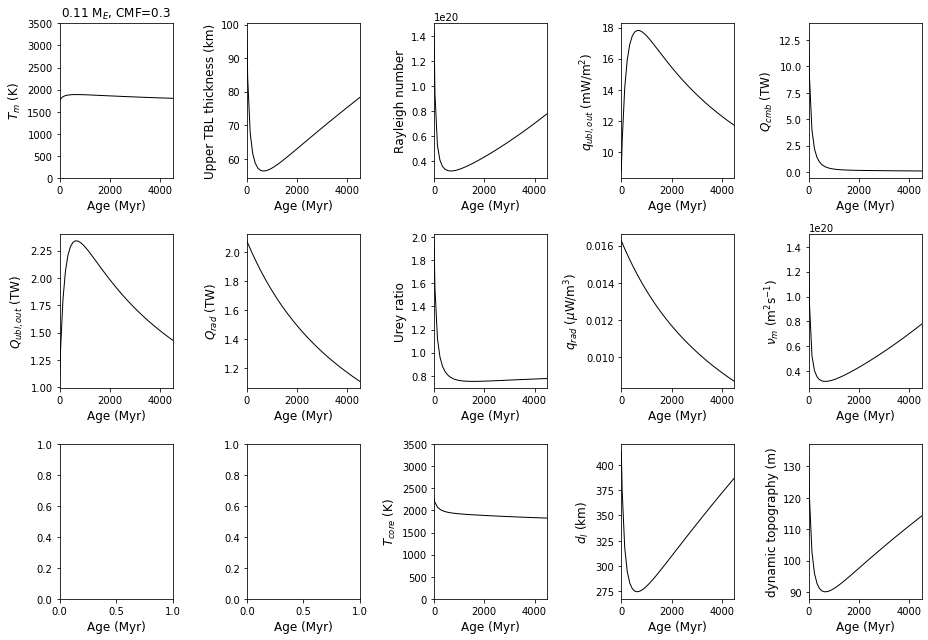

In [278]:
""" reprouce Thiriet+ 2019 Mars1"""
## STOPPED HERE - TRYING TO GET THIS RUNNING WITH NEW d_lid IMPLEMENTATION

Ra_crit = 450
T_m0 = 1750
T_c0 = 2250
rho_m = 3500
rho_c = 7200
rho_lith = 2800
c_v = 1142
c_vc = 840
CMF = 0.3
M_p = 6.39e23/M_E # in M_E
beta_u = None # defaults to 1/3
beta_c = None # defaults to 1/3
a_rh = 2.54
k_m = 4
k_lm = 4
alpha_m = 2.5e-5
T_s = 250
t_f = 4.5
# viscosity 
Ea = 300e3
eta_0 = 1e21
T_ref = 1600


paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_crit_u=Ra_crit, c_pm=c_pm, adiabats=0,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, rho_lith=rho_lith, visc_type='Thi',
                 c_v=c_pm, #<----??? TODO: check if you need constant volume c_p
                 c_vc=c_vc, k_lm=k_lm, beta_u=beta_u, beta_c=beta_c, a_rh=a_rh, 
                 Ea=Ea, eta_0=eta_0, T_ref=T_ref)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=True, fend='', **varargs, **paramargs)

In [252]:
""" baseline case for Earth """

# note:  D^(4/3) = 5Ra_c^(1/3), increasing heat flux out by 5 matches shape of McK&R81

T_m0 = 1800 # initial mantle temp in K
T_c0 = 4000 # initial core temp in K
M_p = 1 # M_E
CMF = 0
t_f = 4.5 # Gyr

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_crit=Ra_crit, c_pm=c_pm, adiabats=2,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, eta_m=eta_m, visc_type='constant',
                 c_v=c_pm, #<----??? TODO: check if you need constant volume c_p
                 c_vc=c_vc, k_lm=k_lm, beta=beta)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)


using Zeng radius model
kappa_m 6.944444444444445e-07


TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [251]:
""" match Nimmo & McKenzie 1997 -- looks not bad"""

T_m0 = 3000 # initial mantle temp in K
T_c0 = 3000 # initial core temp in K
M_p = 1 # M_E
CMF = 0.3
t_f = 4 # Gyr
nu_m=5.5e15
rho_m=4800

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm, eta_m=nu_m*rho_m,
                 alpha_m=4e-5, k_m=3.11, CMF=CMF, rho_c=rho_c, visc_type='constant', adiabats=0,
                 c_v=c_pm, #<----??? TODO: check if you need constant volume c_p
                 c_vc=c_vc, dT_core=dT_core, k_lm=3.11, beta=0.25,
                 T_s=450+273)
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, T_c0=T_c0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)

NameError: name 'dT_core' is not defined

In [ ]:
###### """ reproduce Kite+ 2009 stagnant lid model """

alpha_m = 3e-5
k_m = 4.18
c_pm = 914
rho_m = 3400
CMF = 0.325
T_m0 = 3273

In [ ]:
""" reproduce Venus fig 6 in Driscoll & Bercovici FAILED """
alpha_m = 3e-5
c_pm = 1265
k_m = 4.2
k_lm = 10
rho_m = 4800
M_p = 1 #4.867e24/M_E # M_E
CMF = 0.3
t_f = 4 # Gyr
T_m0 = 2510 # initial mantle temp in K
T_s = 737

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, Ra_c=Ra_c, c_pm=c_pm, T_s=T_s,
                 alpha_m=alpha_m, k_m=k_m, CMF=CMF, rho_c=rho_c, visc_type='Driscoll', nu_m=0,
                 c_v=c_pm, #<----???
                 k_lm=k_lm, beta=beta) 
varargs = dict(M_p=M_p*M_E, a=a*AU2m, T_m0=T_m0, tf=t_f*1e9*years2sec)
t, y = solve_Tm(t0=0, plots=True, plots_save=False, fend='', **varargs, **paramargs)


In [275]:
def d_lid(Tm, a_rh=None, k=None, Ea=None, H0=None, Ra_crit=None, eta_0=None, T_ref=None, 
          kappa_m=None, alpha_m=None, g_sfc=None, rho_m=None, Ts=None, **kwargs):
    # from sympy solution for d
#     print(Tm, a_rh, k, Ea, H0, Ra_crit, eta_0, T_ref, kappa_m, alpha_m, g_sfc, rho_m, Ts)
    #H0 = H0*10 # assume 10x more radioisotopes in lid
    return ((-R_b*Tm**2*a_rh*k + np.sqrt(k*(2.0*Ea**2*H0*Tm*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea**2*H0*Ts*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 - 2.0*Ea*H0*R_b*Tm**2*a_rh*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**0.666666666666667 + R_b**2*Tm**4*a_rh**2*k)))/(Ea*H0*(Ea*Ra_crit*eta_0*kappa_m*np.exp(Ea/(R_b*Tm) - Ea/(R_b*T_ref))/(R_b*Tm**2*a_rh*alpha_m*g_sfc*rho_m))**(1/3)))

In [151]:
# def d_lid(H=None, q_u=None, T_m=None, T_s=None, T_l=None,
#           rho_m=None, k_m=None, **kwargs):
#     if q_u is not None:
#         print('H=', H, 'q_u=', q_u, 'T_m=', T_m)
#         A = -3*H/(2*k_m)
#         B = q_u/k_m
#         C =  T_s - T_l
#         d_1 = np.roots([C, B, A])
#         # two roots
#         if (d_1[0]>0) and (d_1[1]>0):
#             print('two positive roots:', d_1)
#         else:
#             print('one positive root:', np.maximum(d_1[0], d_1[1]))
#         return np.maximum(d_1[0], d_1[1])

In [2]:
import sympy as sym
from sympy.solvers import solve
def d_lid_sympy(Tm_val, H_val, k_val, g_sfc_val, kappa_val, Ra_crit_val, rho_val,
                T0_val, eta0_val, alpha_val, R_b_val, Ea_val, a_rh_val, Ts_val):
    z = sym.Symbol('z')
    Tm = sym.Symbol('Tm') # f(t) 
    H = sym.Symbol('H0') # g(t) # homogenous radiogenic heating in W m^-3
    k = sym.Symbol('k')
    d = sym.Symbol('d') # lid thickness
    Ts = sym.Symbol('Ts')
    a_rh = sym.Symbol('a_rh')
    Ea = sym.Symbol('Ea')
    R_b = sym.Symbol('R_b')
    Ra_crit = sym.Symbol('Ra_crit')
    rho = sym.Symbol('rho')
    alpha = sym.Symbol('alpha')
    g_sfc = sym.Symbol('g_sfc')
    kappa = sym.Symbol('kappa')
    eta0 = sym.Symbol('eta0')
    T0 = sym.Symbol('T0')
    delta_ubl = sym.Symbol('delta_ubl')
    
    values = {k:k_val, g_sfc:g_sfc_val, kappa:kappa_val, Ra_crit:Ra_crit_val, Rc:Rc_val, Rp:Rp_val,
              rho:rho_val, T0:T0_val, eta0:eta0_val, alpha:2.5e-5, R_b:8.3144598, Ea:300e3, a_rh:2.54, Ts:250, H:H_t0}

    eta = eta0*sym.exp(Ea/R_b * (Tm**-1 - T0**-1))
    deltaT_rh = a_rh*R_b*Tm**2/Ea
    Tl = Tm - deltaT_rh # Tl based on viscosity scaling
    Ra_rh = rho*alpha*(Rp - Rc)**3*g_sfc/(kappa*eta) * (Tm-Tl) 
    delta_ubl = (Ra_crit*kappa*eta*Ea/(alpha*rho*g_sfc*a_rh*R_b*Tm**2))**(1/3)  #(h)*(Ra_crit/Ra_rh)**beta
    q_bl = k*(Tm-Tl)/delta_ubl
    q_s = q_bl + H*d # surface heat flux 
    T_z = -H/(2*k)*(z)**2 - q_s/k*(z) + Ts # get expression for T(z)
    Tl_sub = T_z.subs(values).subs(z, -d).subs(Tm,Tm0) # expression for Tl from T(z) profile
    d_1 = solve(Tl_sub - Tl.subs(values).subs(Tm,Tm0), d)
    # two roots
    if (d_1[0]>0) and (d_1[1]>0):
        print('two positive roots')
    else:
        return np.maximum(d_1[0], d_1[1])
    
def lid_thickness(T_l=None, T_s=None, T_m=None, d_u=None, k=None, q_btm=None, **kwargs): 
    """stagnant lid thickness, q is flux into base in W m^-2, T_l is temp at lid base""" 
    return (T_l - T_s)*(k/q_btm) # steady state T(z) profile with no internal radiogenic heating


In [ ]:
"""old thermal model"""

# def Q_bl(T_0, T_outer=None, R=None, R_p=None, k=None, SA=None, g=None, nu_m=None, h=None, 
#          adiabatic=False, **kwargs):
#     """Calculate energy flux from conduction across thermal bdy layer in W""" 
#     d_lid = bdy_thickness(T_0, T_outer, R=R, R_p=R_p, g=g, nu_m=nu_m, h=h, adiabatic=adiabatic,
#                           **kwargs) 
#     T_1 = adiabat(T_0, R=R, g=g, R_p=R_p, h=h, adiabatic=adiabatic, **kwargs)
#     dT = np.absolute(T_1-T_outer)
#     try:
#         return SA*k*dT/d_lid
#     except ZeroDivisionError:
#         return 0

# def dTdt(t, T, T_s=None, Q_core=None, M_m=None, M_c=None, c_v=None, c_vc=None, SA_p=None, SA_c=None, 
#          g_sfc=None, g_cmb=None, R_p=None, R_c=None, k_m=None, k_lm=None, adiabats=0, **kwargs):
#     """R.H.S. of ODE for mantle temperature change"""
#     #print('t, T', t, T)
#     T_m = T[0]
#     T_c = T[1]
#     adiabatic=False
    
#     H_rad = Q_rad(t, M_m=M_m, **kwargs) # radiogenic heating in W
#     if SA_c>0:
#         if adiabats>0:
#             adiabatic=True
#         F_core = Q_bl(T_m, T_c, R=R_c, R_p=R_p, k=k_lm, SA=SA_c, g=g_cmb, c_v=c_v, 
#                       adiabatic=adiabatic, **kwargs) # core flux in W
#         dTdt_c = -F_core/(M_c*c_vc)
#     else:
#         F_core = 0
#         dTdt_c = 0
     
#     if adiabats<2:
#         adiabatic=False
#     F_lid = Q_bl(T_m, T_s, R=R_p, R_p=R_p, k=k_m, SA=SA_p, g=g_sfc, c_v=c_v, 
#                  adiabatic=adiabatic, **kwargs) # *5 # heat flux through lid in W
#     dTdt_m = (-F_lid + H_rad + F_core)/(M_m*c_v)

#     return [dTdt_m, dTdt_c]

# def bdy_thickness(T_0, T_outer=None, R=None, R_p=None, c_v=None, Ra_crit=None, nu_m=None, alpha_m=None, 
#                   g=None, kappa_m=None, beta=None, h=None, adiabatic=False, **kwargs):
#     """Thickness of thermal boundary layer 
    
#     Parameters
#     ----------
#     dT : float
#         Temperature difference across boundary
#     Ra_crit : float
#         Critical Rayleigh number
#     alpha_m : float 
#         Thermal expansivity in
#     kappa_m : float 
#         Thermal diffusivity in
#     nu_m : float
#         Mantle kinematic viscosity 
#     g : float
#         Acceleration due to gravity in m s^-2
#     h : float
#         Layer thickness in m
    
        
#     Returns
#     -------
#     d : float
#         Lid thickness in m
#     """
#     T_1 = adiabat(T_0, R=R, g=g, R_p=R_p, c_v=c_v, h=h, alpha_m=alpha_m, adiabatic=adiabatic, **kwargs)
#     dT = np.absolute(T_1-T_outer)
#     vi = visc(T_1, nu_0=nu_m, **kwargs) # viscosity
#     # Set Rayleigh number at critical value
#     try:
#         return h*(Ra_crit*vi*kappa_m/(alpha_m*g*dT*h**3))**(beta)
#     except ZeroDivisionError: 
#         return 0   

# def plot_results(f, **kwargs):
#     print('R_p =', '%.2f'%(kwargs['R_p']/R_E), 'R_E')
#     #print('M_mantle', '%.2f'%(kwargs['M_m']/M_E), 'M_E')
#     print('g_sfc =', '%.2f'%kwargs['g_sfc'], 'm s^-2')
#     print('g_cmb =', '%.2f'%kwargs['g_cmb'], 'm s^-2')
#     #print('SA_p =', '%.2f'%(kwargs['SA_p'])
#     print('SA_c =', '%.2f'%(kwargs['SA_c']/kwargs['SA_p']), 'x SA_p')
#     print('CRF =', '%.2f'%kwargs['CRF'])
#     print('T_s =', '%.2f'%kwargs['T_s'], 'K')
#     print('viscosity method:', kwargs['visc_type'])
#     rad_heating = Q_rad(f.t, t_vect=True, **kwargs)
#     adiabatic=False
#     if kwargs['adiabats']>0:
#         adiabatic=True
#     core_heating = Q_bl(f.y[0], f.y[1], R=kwargs['R_c'], k=kwargs['k_lm'], 
#                         SA=kwargs['SA_c'], g=kwargs['g_cmb'], adiabatic=adiabatic, 
#                         **kwargs)
#     if kwargs['adiabats']<2:
#         adiabatic=False
#     cond_cooling = Q_bl(f.y[0], kwargs['T_s'], R=kwargs['R_p'], k=kwargs['k_m'], 
#                         SA=kwargs['SA_p'], g=kwargs['g_sfc'], adiabatic=adiabatic,
#                         **kwargs) #*5
#     d_lid = bdy_thickness(f.y[0], kwargs['T_s'], R=kwargs['R_p'], adiabatic=False,
#                           g=kwargs['g_sfc'], **kwargs)
#     urey = rad_heating/cond_cooling

#     fig, axes = plt.subplots(3, 5, figsize=(13,9))
#     plot_one(axes[0][0], f.t*1e-6/years2sec, 
#              f.y[0],
#              '', '$T_m$ (K)', ylim=[0, 3500])
#     #plot_structure(axes[0][1], R_p, R_cmb)
#     plot_one(axes[0][1], f.t*1e-6/years2sec, 
#              d_lid*1e-3, 
#              '', 'Lid thickness (km)')
#     plot_one(axes[0][2], f.t*1e-6/years2sec, 
#              Ra(nu=kwargs['nu_m'], kappa=kwargs['kappa_m'], alpha=kwargs['alpha_m'], rho=kwargs['rho_m'],
#                 g=kwargs['g_sfc'], deltaT=f.y[0]-[kwargs['T_s']]*len(f.y[0]), 
#                 l=kwargs['h']), 
#                 '', 'Rayleigh number')

#     plot_one(axes[1][0], f.t*1e-6/years2sec, 
#              cond_cooling*1e-12, 
#              '', '$Q_{lid,out}$ (TW)')
#     plot_one(axes[1][1], f.t*1e-6/years2sec, 
#              rad_heating*1e-12,
#              '', '$Q_{rad}$ (TW)')
#     plot_one(axes[1][2], f.t*1e-6/years2sec, 
#              urey, 
#              '', 'Urey ratio')
#     plot_one(axes[0][3], f.t*1e-6/years2sec, 
#              cond_cooling/derargs['SA_p']*1e3, 
#              '', '$q_{lid,out}$ (mW/m$^2$)')
#     plot_one(axes[1][3], f.t*1e-6/years2sec, 
#              rad_heating/kwargs['M_m']*kwargs['rho_m']*1e3,
#              '', '$q_{rad}$ (mW/m$^3$)')
#     try:
#         plot_one(axes[0][4], f.t*1e-6/years2sec, 
#                  core_heating*1e-12, 
#                  '', '$Q_{cmb}$ (TW)')
#     except ValueError:
#         pass
#     try:
#         plot_one(axes[1][4], f.t*1e-6/years2sec, 
#                  visc(f.y[0], nu_0=kwargs['nu_m'], **kwargs),
#                  '', r'$\nu_{m}$ (m$^2$s$^{-1}$)')
#     except ValueError:
#         plot_one(axes[1][4], f.t*1e-6/years2sec, 
#                  [kwargs['nu_m']]*len(f.t),
#                  '', r'$\nu_{m}$ (m$^2$s$^{-1}$)')
#     plot_one(axes[2][0], f.t*1e-6/years2sec, 
#              adiabat(f.y[0], kwargs['R_p'], kwargs['g_sfc'], adiabatic=True, **kwargs, **derargs), 
#              '', '$T_{UM}$ (K)')
#     plot_one(axes[2][1], f.t*1e-6/years2sec, 
#              adiabat(f.y[0], kwargs['R_c'], kwargs['g_cmb'], adiabatic=True, **kwargs, **derargs),
#              '', '$T_{LM}$ (K)')
#     plot_one(axes[2][3], f.t*1e-6/years2sec, 
#              urey**-1,
#              '', '$E/F(t)$')
#     plot_one(axes[2][2], f.t*1e-6/years2sec, 
#              f.y[1],
#              '', '$T_{core}$ (K)', ylim=[0, 3500])
#     plot_one(axes[2][4], f.t*1e-6/years2sec, 
#              dyn_topo(cond_cooling/derargs['SA_p'], rho_w=0, **kwargs, **derargs),
#              '', 'topo height (m)')
#     plot_setxlabel(axes, 'Age (Myr)', 'all')
#     axes[0][0].set_title(str(M_p/M_E)+' M$_E$, CMF='+str(CMF))
#     plt.tight_layout()
#     if plots_save:
#         fig.savefig('figs/evol_M'+'%.2f'%(M_p/M_E)+'_CMF'+str(CMF)+fend+'.pdf', bbox_inches='tight')